# INFO-f422: ML Project

authors:
+ 1 
+ 2
+ 3

### Imports

In [1]:
import warnings
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(threshold=3)

### Data loading

In [2]:
data_dir = "data"

X_g_train = np.load("../guided/guided_dataset_X.npy")
y_g_train = np.load("../guided/guided_dataset_y.npy")
X_g_test = np.load("../guided/guided_testset_X.npy")

X_f_train = np.load("../freemoves/freemoves_dataset_X.npy")
y_f_train = np.load("../freemoves/freemoves_dataset_y.npy")
X_f_test = np.load("../freemoves/freemoves_testset_X.npy")


In [3]:
print("Guided:")
print(f"X_g_train {X_g_train.shape} / y_g_train{y_g_train.shape} / X_g_test{X_g_test.shape}\n")
print("Free moves:")
print(f"X_f_train{X_f_train.shape} / y_f_train{y_f_train.shape} / X_f_test{X_f_test.shape}")

Guided:
X_g_train (5, 8, 230000) / y_g_train(5, 51, 230000) / X_g_test(5, 332, 8, 500)

Free moves:
X_f_train(5, 8, 270000) / y_f_train(5, 51, 270000) / X_f_test(5, 308, 8, 500)


### 1) Signal filtering

TODO: data exploration to take informed decision on filter (type of noise,....) to use and on filter parametres (no magic number)

In [4]:
from scipy.signal import butter, sosfiltfilt, firwin

In [5]:
nyq  = 1024 / 2
low  = 20  / nyq
high = 450 / nyq

sos = butter(4,[low,high], btype='band', output= 'sos')

for sess in range(X_g_train.shape[0]):
    for elec in range(X_g_train.shape[1]):
        # Application of the filtrage for x
        X_g_train[sess, elec, :] = sosfiltfilt(sos, X_g_train[sess, elec, :])

### 2) Dataset preparation

At the beginning, we implemented a naive function that loops for each windows needed. 

This version work but:
- Only when the step size can divides the total number of samples.  
- Copies every window into a new array, incurring  CPU overhead and unnecessary memory usage. 

In [6]:
def overlap(data, overlap=0.5, size=500):
    Data = []
    step = int(size * (1 - overlap))
    n = (data.shape[2] - size) // step + 1
    fin = n * step
    
    for start in range(0, fin, step):
        end = start + size
        W = data[... , start:end]
        Data.append(W)
        
    Data = np.array(Data)
    Data = Data.transpose(1, 0, 2, 3)
    return Data

But after some research, we decided to use the sliding_window_view function from the Numpy library for several reasons:

+ Fast vectorized numpy operations, compiled c-code (no python overhead, interpreter).

+ sliding_window_view function returns a view, no copy.

+ The function simplifies the implementation by automating window creation and indexing.

In [7]:
def create_overlap_windows(x, y, window_size, overlap, axis):

    step = int(window_size * (1 - overlap))

    # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
    x_w = sliding_window_view(x,window_size,axis)
    y_w = sliding_window_view(y,window_size,axis)

    # only keep windows where the step is a multiple of our step 
    x_w = x_w[:,:,::step,:]
    y_w = y_w[:,:,::step,:]

    # We transpose the axes windows and electrode/signal 
    x_w = x_w.transpose(0, 2, 1, 3)     #  (session, window, electrode, time) and not  (session, electrode, window, time) TODO??
    y_w = y_w.transpose(0, 2, 1, 3)     # (session, window, signals, time)

    # Finaly, we keep only the last hand position (targets) for y, because for this project
    # we need to predict, for each window in x, the final hand position in the
    # same windows in the dataset y
    y_w = y_w[..., -1]  # (sessions, windows, targets)

    return x_w, y_w


X_g_train_wdw, y_g_train_wdw = create_overlap_windows(X_g_train, y_g_train, window_size=500, overlap=0.5, axis=2)
# !! windowed data is a view --> share original data memory (modify one, modify both)

print("Guided windowed:")
print(f"X_g_train_wdw {X_g_train_wdw.shape} / y_g_train_wdw{y_g_train_wdw.shape} / X_g_test{X_g_test.shape}")

Guided windowed:
X_g_train_wdw (5, 919, 8, 500) / y_g_train_wdw(5, 919, 51) / X_g_test(5, 332, 8, 500)


In [8]:
def quick_windows_tests(x, y):
    # (maybe automate tests given windowsize and overlap and consider internal frag (shoudl be discarded)
    
    x_w, y_w = create_overlap_windows(x, y, window_size=500, overlap=0.5, axis=2)    
    
    assert np.array_equal(x_w[0, 0, 0, :10], x[0, 0, :10]) # (sess 0) first 10 of electrode 0 in window 0
    assert np.array_equal(x_w[0, 1, 0, :10], x[0, 0, 250:260]) # (sess 0) first 10 of electrode 0 in window 1
    assert np.array_equal(x_w[0, 1, 4, :10], x[0, 4, 250:260]) # (sess 0) first 10 of electrode 4 in window 1
    assert np.array_equal(x_w[0, 918, 0, -10:], x[0, 0, 229990:230000]) # (sess 0) last 10 of electrode 0 in last window (918) - (perfect fit!)

quick_windows_tests(X_g_train, y_g_train)

#### 3) Cross validation strategy

For this question, we have thought about various methods of cross validation. First, our data are continous because it's a signal, so preserving temporal structure is important. We can’t use a method of cross validation which randomly shuffles our windows. 

We also need to prevents data leaking so we can't use a methode who use the windows of one session for training AND validation because we have overlapping data in each session, two windows in the same session can share the same datas, and if these two windows are in train and validation, it will lead to data leakage and overly optimistic performance (data in the train set will also be in the validation set). 

So it's naturally that we have chosen the "Leave One Group Out" method, this method will use each session as the validation set once and the other for training. We completly prevent data leakage because each session is indepandent from the other, and we reduce the bias because each session will be used for validation.

In our case, "LOGO" and "GroupKFold(5)" produce the same splits, but we choose "LOGO" because it's more explicit, readers will immediatly see that we use one session for validation each time while "GroupKFold" need to have 5 in parameter to do the same thong

In [9]:
x_shape = X_g_train_wdw.shape
y_shape = y_g_train_wdw.shape

groups = np.repeat(np.arange(1,x_shape[0]+1),x_shape[1] ) # 111 (919 times), 222 (919 times), ...
print(f"groups{groups.shape}\n")

# We need to flatten the dataset x and y because the function logo (and latter "croos_val_score")
# want all the data in a 2d list, we will know have  the dataset X for exemple.
# [4595, 4000] and not [5,919,8,500], 4595 is the multiplication of 5 and 919 (3500 = 8*500), and y 
# [4595,51] and not [5,919,51].
# Now all the windows are store in a list and the "groups" list above allow the function 
# logo to know at wich session each windows belong
# The windows 3 for example (x_windows_flat[2]) belong to the sessions groups[2] = 1
X_g_train_wdw_flat = X_g_train_wdw.reshape(x_shape[0] * x_shape[1], x_shape[2] * x_shape[3])
y_g_train_wdw_flat = y_g_train_wdw.reshape(y_shape[0] * y_shape[1], y_shape[2])

print("Guided windowed flattened:")
print(f"X_g_train_wdw_flat{X_g_train_wdw_flat.shape} / y_g_train_wdw_flat{y_g_train_wdw_flat.shape}")

groups(4595,)

Guided windowed flattened:
X_g_train_wdw_flat(4595, 4000) / y_g_train_wdw_flat(4595, 51)


In [10]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [11]:
# %%time

# np.random.seed(0)

logo = LeaveOneGroupOut()

lasso_model = Lasso(max_iter=10) # the futur model 
ridge_model = Ridge()

rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False  # Score near 0 is better 
)

def cross_validation_with_scores(X,Y,groups,model,cv,scoring):
    # The cross_val_score function by sklearn will execute our cv and return a tab 
    neg_rmse_scores = cross_val_score(
        model,
        X,
        Y,
        groups=groups,
        cv=logo,
        scoring=rmse_scorer,
        n_jobs=-1 # Use all cores 
    )
    
    # Conversion of negatifs scores into positifs (convention of sklearn)
    rmse_scores = -neg_rmse_scores  
    print("RMSE for each folder:", rmse_scores)

cross_validation_with_scores(X_g_train_wdw_flat,y_g_train_wdw_flat,groups,lasso_model,logo,rmse_scorer)

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.302e+03, tolerance: 4.404e+00
  model = cd_fast.enet_coordinate_descent(
/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.785e+03, tolerance: 4.776e+00
  model = cd_fast.enet_coordinate_descent(
/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

RMSE for each folder: [19.80889373 20.70289974 23.42573968 20.45592827 21.90544978]


/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.782e+05, tolerance: 1.351e+02
  model = cd_fast.enet_coordinate_descent(


In [13]:
# rmse context
sess = 0
y_max = np.max(y_g_train_wdw[sess])
y_min = np.min(y_g_train_wdw[sess])
y_mean = np.mean(y_g_train_wdw[sess])

print(f"Session {sess} target info:\n  min = {y_min}\n  max = {y_max}\n  mean = {y_mean}")

Session 0 target info:
  min = -108.68231864942676
  max = 44.76897408739836
  mean = -5.73247691191569


In [14]:

for i, (train_index, test_index) in enumerate(logo.split(X_g_train_wdw_flat, y_g_train_wdw_flat, groups)):
    print(f"Fold {i}")
    print(f"   train groups: {np.unique(groups[train_index])}")
    print(f"   test groups: {np.unique(groups[test_index])}")

Fold 0
   train groups: [2 3 4 5]
   test groups: [1]
Fold 1
   train groups: [1 3 4 5]
   test groups: [2]
Fold 2
   train groups: [1 2 4 5]
   test groups: [3]
Fold 3
   train groups: [1 2 3 5]
   test groups: [4]
Fold 4
   train groups: [1 2 3 4]
   test groups: [5]


#### 5) More sophisticated approach

For this question, we decided to implement the two approaches in order to have a better understanding and more methods to compare.

We started with the covariance approch, following the steps in section 3.2:

- We first calculate the covaraince of each windows with the PyRiemmann Covariances class, which expects a 3d array, so we need to reshape it into the form (windows,electrode,time). After using this class, we obtain an array of 8×8 covariance matrices (SPD_tab) for each window.

- Next, we map each SPD matrix into their tangent space using the TangentSpace class. This projection transforms our SPD matrices into Euclidean vectors. Thanks to this, our dataset becomes 2D again, and we can directly use a traditional regression algorithms and sklearn function.
  

In [15]:
#pip install pyriemann
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace


In [16]:
# Covariances method

# Reshape the flattten dataset
X_g_train_reshape = X_g_train_wdw_flat.reshape(4595,8,500)

# Covariances matrices of each windows
covariance = Covariances(estimator='oas')
SPD_tab = covariance.fit_transform(X_g_train_reshape) 
# print(SPD_tab.shape) # (4595,8,8)

# This projection will transform our SPD matrices into euclidean vector 
ts = TangentSpace()
tangent_tab = ts.fit_transform(SPD_tab)
# print(tangent_tab.shape) # (4595,36) Now that we have a 2d tab, we can use traditional regression algorithms


# Now we juste need to use the cv function we build above 
cross_validation_with_scores(tangent_tab,y_g_train_wdw_flat,groups,lasso_model,logo,rmse_scorer)

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e+03, tolerance: 4.204e+01
  model = cd_fast.enet_coordinate_descent(
/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.498e+03, tolerance: 5.580e+01
  model = cd_fast.enet_coordinate_descent(
/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

RMSE for each folder: [8.77911528 8.27891509 8.21374781 7.32334406 8.3483254 ]


/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e+03, tolerance: 4.038e+01
  model = cd_fast.enet_coordinate_descent(
/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.162e+02, tolerance: 5.997e+01
  model = cd_fast.enet_coordinate_descent(
/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

The performance improvement is clear compared to the vanilla model

For the neural network approch,  we started by a simple model compose of 3 linear couche and 2 hidden one. For testing this model, i use the librairie Skorch, thiss librairy allow to use sklearn with our neural network in pytorch. 
Thank to this librairy, i can directly re-use our "cross_validation_with_scores()" function.

We try several model and different setting and we have keep the best one .


the rmse resultat for each fold was [16.64994237 16.95370193 16.68780083 16.83642147 17.23919605] (fait une moyenne), this was better than the vanilla lasso model but not than the covriance matrices lasso. We analyzed the value of the training loss and validation loss for each epoch and we see that the model is underfitting.

After having realized that, we decided to complexify our model.

We



In [24]:
# pip install -U skorch
import torch
import torch.nn as nn
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from skorch.callbacks import LRScheduler



In [56]:
## NN method

# 1st version
'''
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack  = nn.Sequential(
            nn.Linear(4000, 512), # 4000 datas in one windows
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 51)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


'''
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Unflatten(1, (8,500)), #unflatten our data for using convolution (64 (batch_size), 8,500)

            nn.Conv1d(8, 32, kernel_size=11, padding=5), # 8 is the number au canal ( the 8 signals) and 32 is the output, the number of feature he learn.
            # Thank to the padding, we conserv the same lengh for our data (64,32,500) 
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),  # Cut by 2 the temps data (64,32,250)          
            
            nn.Conv1d(32, 64, kernel_size=9, padding=4), #(64,64,250)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),  #(64,64,125)      

            nn.Conv1d(64, 128, kernel_size=7, padding=3), # (64,128,125)
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),  # (64,128,62)    
            
            nn.Flatten(), # Reflatten our data for the next part (64,128*62)
        )
        self.r = nn.Sequential(
            nn.Linear(7936, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 51),
        )

    def forward(self, x):
        x = self.f(x)
        return self.r(x)

      
# We need to convert the dataset type from float64 to float32 because pyTorch nn.Linear  are in float32
# This will not affect our data because 32 bits is stil massive and our emg signal don't take that much space
print(X_g_train_wdw_flat.dtype)   
print(y_g_train_wdw_flat.dtype)   

x = X_g_train_wdw_flat.astype('float32')
y = y_g_train_wdw_flat.astype('float32')


net = NeuralNetRegressor(
    module=NeuralNetwork,                 # model 
    max_epochs=100,                 
    lr=1e-3,                       
    batch_size=64,
    optimizer=torch.optim.Adam,
    callbacks=[('earlystop', EarlyStopping('valid_loss', patience=5)), # The process will stop if the valid_loss has not improved for 5 epochs 
                    ('lr_sched', LRScheduler(
           policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
           monitor='valid_loss',
           patience=3, factor=0.5))]
)


cross_validation_with_scores(x,y,groups,net,logo,rmse_scorer)




float64
float64


/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      197.1949      132.2520  0.0010  11.0224
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      197.5727      129.9286  0.0010  11.1359
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      201.3044      147.0221  0.0010  12.1153
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      195.5417      152.9299  0.0010  12.2071
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      193.6325      135.9495  0.0010  12.1935
      2      100.3985       88.6345  0.0010  12.2687
      2       98.6738 

  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      237.6878      183.2983  0.0010  4.3590
      2      161.4224      136.5558  0.0010  4.0776
      3      116.2284      104.8984  0.0010  4.0603
      4       89.8094       78.6879  0.0010  4.0141
      5       77.1333       85.1780  0.0010  3.9627
      6       72.4124       79.4206  0.0010  4.4627
Stopping since valid_loss has not improved in the last 5 epochs.
      7       64.4215       55.3910  0.0010  4.6483
      8       59.2631       69.3639  0.0010  4.6573
      9       55.7976       69.0909  0.0010  4.5202
     10       54.1109       97.8715  0.0010  4.5551
     11       45.4230       47.8217  0.0010  4.4158
     12       41.8093       30.0578  0.0010  4.6390
     13       34.6041       36.2197  0.0010  4.4985
     14       28.4584       33.0954  0.0010  4.5776
     15       25.4434       28.3948  0.0010  4.5412
     16       24.7861       26.2726  0.0010  4.5949

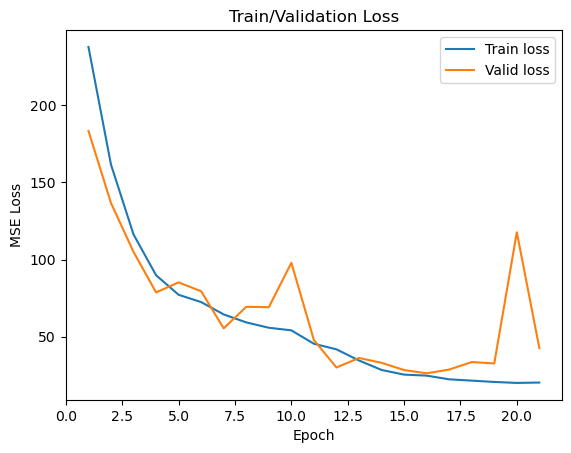

Stopping since valid_loss has not improved in the last 5 epochs.
Stopping since valid_loss has not improved in the last 5 epochs.
Stopping since valid_loss has not improved in the last 5 epochs.
Stopping since valid_loss has not improved in the last 5 epochs.


In [52]:
import matplotlib.pyplot as plt

net.fit(x, y)

history = net.history

epochs = history[:, 'epoch']
train_loss = history[:, 'train_loss']
valid_loss = history[:, 'valid_loss']

plt.plot(epochs, train_loss, label='Train loss')
plt.plot(epochs, valid_loss, label='Valid loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Train/Validation Loss')
plt.legend()
plt.show()

| Simple Model | Complex Model | Complex Model + Early Stopping & LR Scheduler | Same as #3 but Batch Size = 64 |
|:------------:|:-------------:|:---------------------------------------------:|:-----------------------------:|
| ![](./images/1.png) | ![](./images/2.png) | ![](./images/3.png) | ![](./images/4.png) |
| **RMSE mean:** 17.03 | **RMSE mean:** 6.06 | **RMSE mean:** 5.89 | **RMSE mean:** 5.07 |


4) more complexe model

1) simple model with 20 epochs : RMSE for each folder: [16.4083797  16.94704762 18.03045113 17.58527979 16.17519025]

2 . More complexe model : RMSE for each folder: [6.84311147 5.80517707 6.54289966 4.21862951 6.88119477]

3 Complexe model and an early stop/ lower learning rate when the valid loss stagnate for 5/3 epochs RMSE for each folder:  [7.19340657 5.34444383 8.04984443 3.75273109 5.09772491]

4. Same than 3 but batch size = 64 rather than 128 [5.44124623 5.48683742 5.65531939 4.29961871 5.42236449]
 [7.5106573  4.82264888 5.59050925 3.78478284 3.62422619]